In [141]:
# Data storage.
import numpy as np
import pandas as pd 
pd.set_option('mode.chained_assignment', None) 

# Visualization.
from matplotlib import pyplot as plt 
import seaborn as sb 

# Preprocessing.
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Classifiers.
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Performance metrics.
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


# Reading in data.
data = pd.read_csv('https://raw.githubusercontent.com/udacity/machine-learning/master/projects/titanic_survival_exploration/titanic_data.csv')

# Checking feature types and for missing values.
# Features are categorical and continuous.
# Missing values from 891 total passengers: Age(180), Cabin(800), Embarked(2). 
print(data.info())

# Checking basic dataset measures. 
# Nothing glaring but more analysis to come. 
print('\n' + str(data.describe()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0

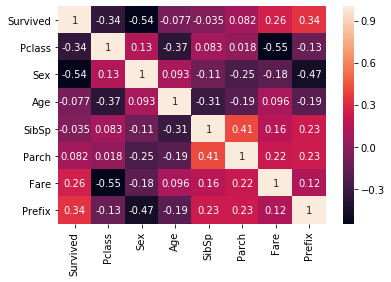

In [142]:
# Column information.
columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
cols_to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name'] # Not informative or missing too many values. 
cols_to_encode = ['Pclass', 'Embarked', 'Prefix']
cols_to_scale = ['Age', 'SibSp', 'Parch', 'Fare']

# Encoding Sex:
data.loc[data['Sex'] == 'female', 'Sex'] = 0
data.loc[data['Sex'] == 'male', 'Sex'] = 1

# Imputing the 2 missing embarked values with most common value. S:646, Q:168, C:77, therefore replacing with S.
data['Embarked'].fillna('S', inplace=True)

# Grouping similar prefixes together ie Mrs, Mme, Ms as one group.
# Count of each prefix: 'Mr.':501, 'Mrs.':120, 'Miss.':178, 'Master.':39, 'Don.':0, 'Rev.':5, 
#                       'Dr.':6, 'Mme.':0, 'Ms.':0, 'Major.':1, 'Mlle.':1, 'Col.':1, 'Capt.':0 'Jonkheer.':0
prefix = {'Mr.': 1, 'Mrs.': 2, 'Mme.': 2, 'Ms.': 2, 'Miss.': 3, 'Mlle.': 3, 
          'Master.': 4, 'Don.': 5, 'Rev.': 6, 'Dr.': 7,  'Major.': 8, 'Col.': 8, 
          'Capt.': 8, 'Jonkheer.': 8, 'Sir':8, 'the Countess.':8}

# Parsing name prefix, and assigning to group, some people have multiple first names. 
# Names that cannot be parsed are given either Mr or Mrs depending on value for sex. 
data['Prefix'] = np.nan
data['Prefix'] = data['Name'].str.split().str[1].map(prefix)
data['Prefix'].fillna(data['Name'].str.split().str[2].map(prefix), inplace=True)
data['Prefix'].fillna(data['Sex'].map({1:1, 0:2}), inplace=True)

# Dropping uninformative features. 
data = data.drop(cols_to_drop, axis='columns')

# Heatmap showing correlations between features.
sb.heatmap(data.corr(), annot=True)
plt.show()

# Heatmap Analysis:
# - Moderate correlations(.20-.40): Pclass x Survived, Age x Pclass, SibSp x Age, Fare x Survived, Prefix x Survived.
# - Strong correlations(.40+): Sex x Survived, Parch x SibSp, Fare x Pclass, Prefix x Sex.
# - Basically Pclass and sex had the most impact on a persons chances of surviving.  

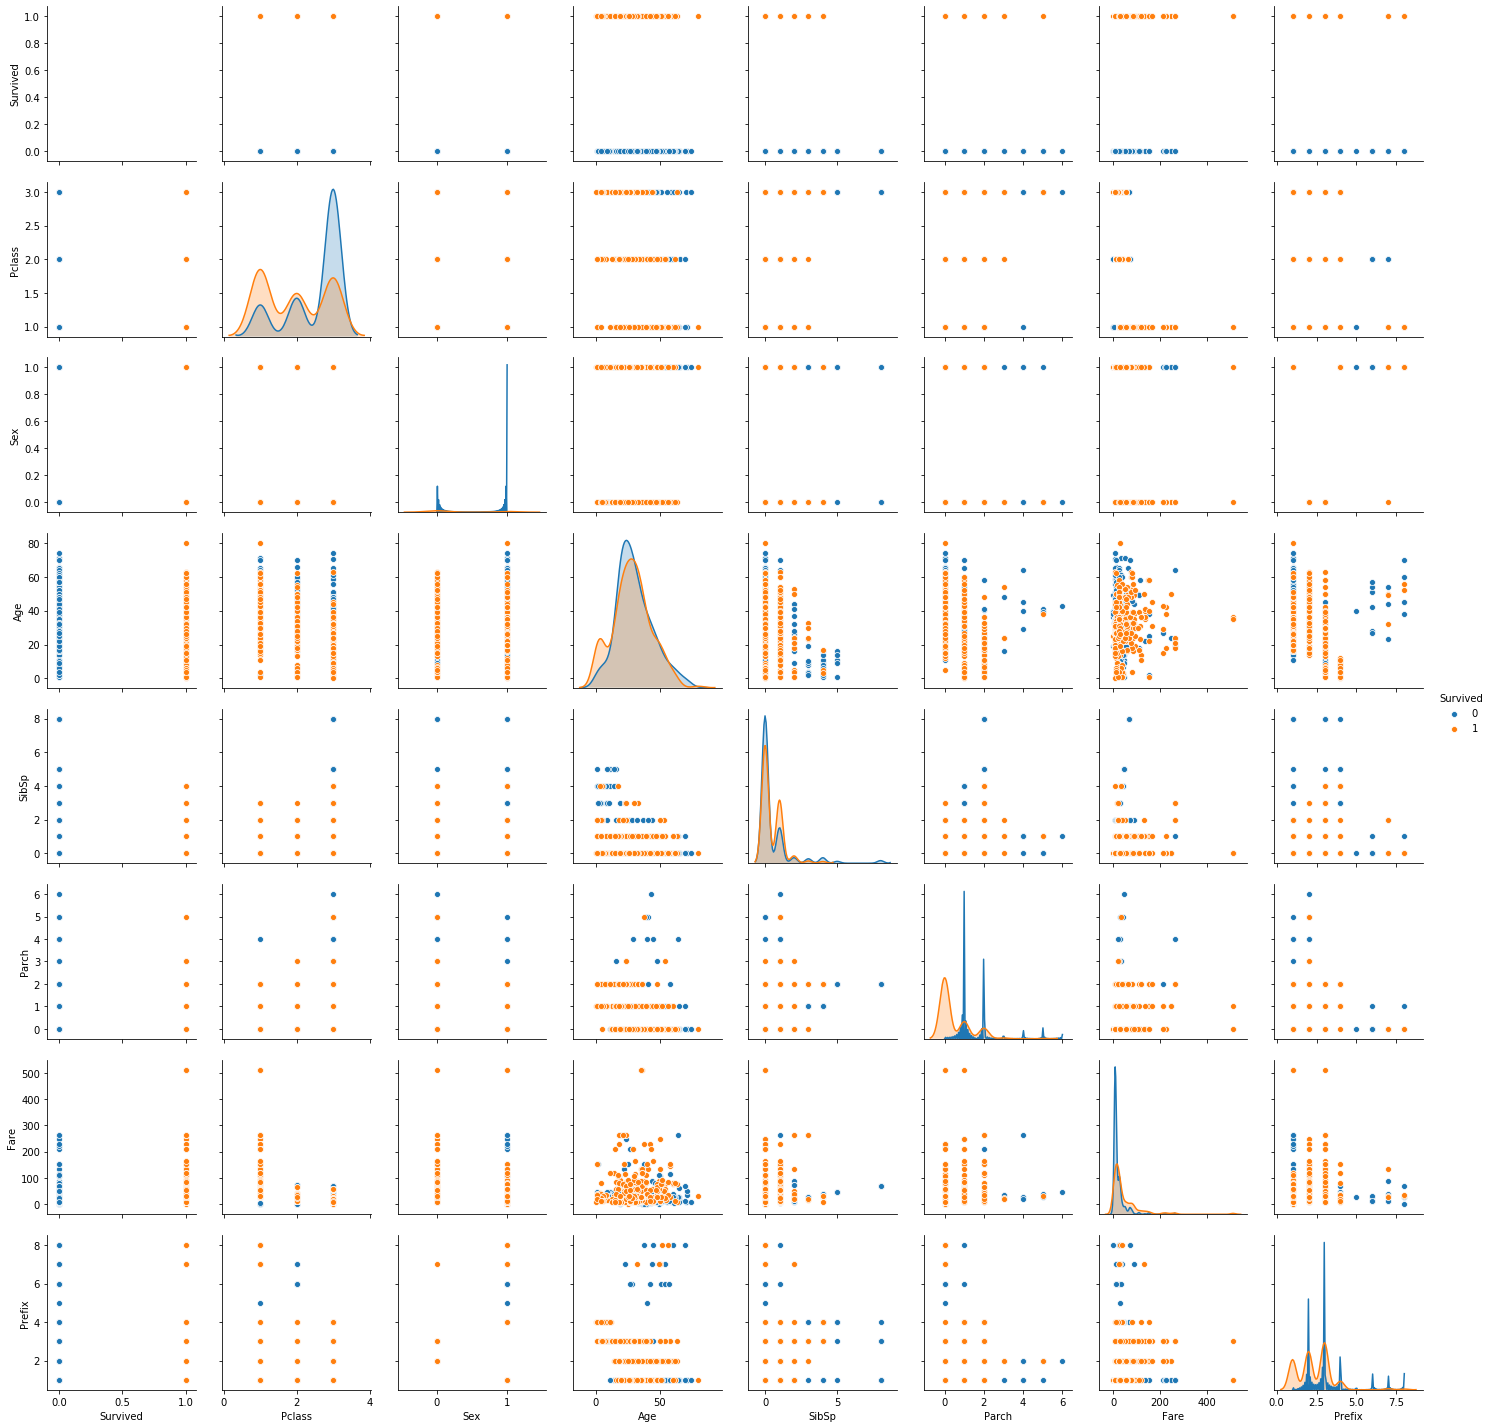

In [143]:
# Ignoring divide errors while creating pairplots. Warning are due to nan values which will be imputed.  
np.seterr(divide='ignore', invalid='ignore')

# Pairplot showing joint and marginal distributions.
sb.pairplot(data, hue='Survived')
plt.show()

# Pairplot Analysis: 
# People with more than 4 SibSp did not survive.
# People in Pclass 1, regardless of age mainly survived. More older people in Pclass 2 & 3 died.
# Most people that died were from Pclass 3. 
# More females survived(233/314) even though there were more males(109/577). 
# There were lots of people either travelling alone or with a single companion.

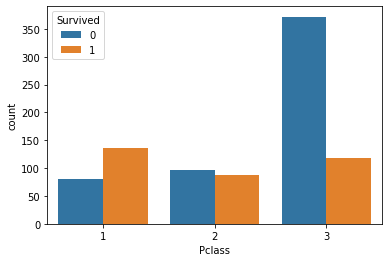

In [144]:
# Count of survivors and victims in each Pclass
sb.countplot(x='Pclass', data=data, hue='Survived')
plt.show()

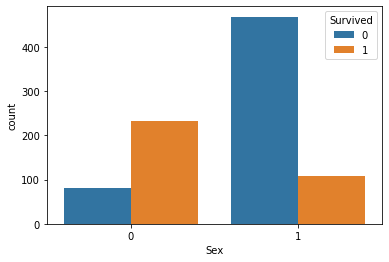

In [145]:
# Count of survivors and victims of each sex. 
# More females survived(233/314) even though there were more males(109/577). 
sb.countplot(x='Sex', data=data, hue='Survived')
plt.show()

In [146]:
# OneHotEncoding Shortcut. Columns are automatically dropped, and replaced by sparse matrix.
encoded_data = pd.get_dummies(data, columns=cols_to_encode, prefix=['Pclass', 'Embarked', 'Prefix'])

# Splitting data.
y = encoded_data['Survived'].copy()
x = encoded_data.drop(['Survived'], axis='columns')

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Imputing for age using its best predictors (Pclass, Parch, and SibSp), and the KNN algorithm. 
cols_to_impute_age = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp', 'Parch', 'Age']
age_train = x_train[cols_to_impute_age].copy()
age_test = x_test[cols_to_impute_age].copy()

knn_imputer = KNNImputer().fit(age_train)
age_train = pd.DataFrame(knn_imputer.transform(age_train), columns=cols_to_impute_age)
age_test = pd.DataFrame(knn_imputer.transform(age_test), columns=cols_to_impute_age)

# Updating training and test sets with imputed age feature. 
x_train.loc[:, 'Age'] = age_train['Age'].values
x_test.loc[:, 'Age'] = age_test['Age'].values

# Scaling required columns.
ct = ColumnTransformer([('scale', StandardScaler(), cols_to_scale)])
scaled_data_train = pd.DataFrame(ct.fit_transform(x_train), columns=cols_to_scale)
scaled_data_test = pd.DataFrame(ct.transform(x_test), columns=cols_to_scale)

# Updating training and test sets with scaled features. 
x_train.loc[:,('Age')] = scaled_data_train['Age'].values
x_train.loc[:,('SibSp')] = scaled_data_train['SibSp'].values
x_train.loc[:,('Parch')] = scaled_data_train['Parch'].values
x_train.loc[:,('Fare')] = scaled_data_train['Fare'].values

x_test.loc[:,('Age')] = scaled_data_test['Age'].values
x_test.loc[:,('SibSp')] = scaled_data_test['SibSp'].values
x_test.loc[:,('Parch')] = scaled_data_test['Parch'].values
x_test.loc[:,('Fare')] = scaled_data_test['Fare'].values

In [147]:
# Trains classifiers, optimizes hyperparameters using grid search and outputs predictions metrics. 
def train_and_predict(classifier, params):
    
    clf = GridSearchCV(classifier, params)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, pred)}')
    print(f'F1 Score: {f1_score(y_test, pred)}')
    print(confusion_matrix(y_test, pred))
    
# Parameter(s) for tuning each classifier. 
tree_params = { 'n_estimators' : [50,75,100,125] }
knn_params =  { 'n_neighbors': [5, 7, 9, 11] }
mlp_params =  { 'solver' : ['adam', 'sgd'],'activation' : ['logistic', 'relu'], 'hidden_layer_sizes' : [(80),(90),(100)]}
    
# GradientBoosting Classifier. 
print('--Gradient Boosting Classifer--')
train_and_predict(GradientBoostingClassifier(), tree_params)

# RandomForest Classifier. 
print('--Random Forest Classifer--')
train_and_predict(RandomForestClassifier(), tree_params)

# KNN Classifier.
print('--KNN Classifier--')
train_and_predict(KNeighborsClassifier(), knn_params)

# MLP Classifier.
print('--MLP Classifier--')
train_and_predict(MLPClassifier(early_stopping=True, max_iter=500), mlp_params)

# Post Classification Analysis:
# - All selected classifiers performed well, with gradientboostingclassifier performing the best.

# Possible Next Steps:
# - Make age feature categorical (increments of 5 or 10 years).
# - Further analyze ticket and cabin features. At current state, they don't hold much insight.  

--Gradient Boosting Classifer--
Accuracy: 0.8609865470852018
F1 Score: 0.8098159509202455
[[126  13]
 [ 18  66]]
--Random Forest Classifer--
Accuracy: 0.8430493273542601
F1 Score: 0.7741935483870968
[[128  11]
 [ 24  60]]
--KNN Classifier--
Accuracy: 0.8116591928251121
F1 Score: 0.7341772151898734
[[123  16]
 [ 26  58]]
--MLP Classifier--
Accuracy: 0.7892376681614349
F1 Score: 0.6666666666666666
[[129  10]
 [ 37  47]]
